In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import pickle
import collections
import glob
import json
import utils
from tqdm import tqdm

import matplotlib.pyplot as plt
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

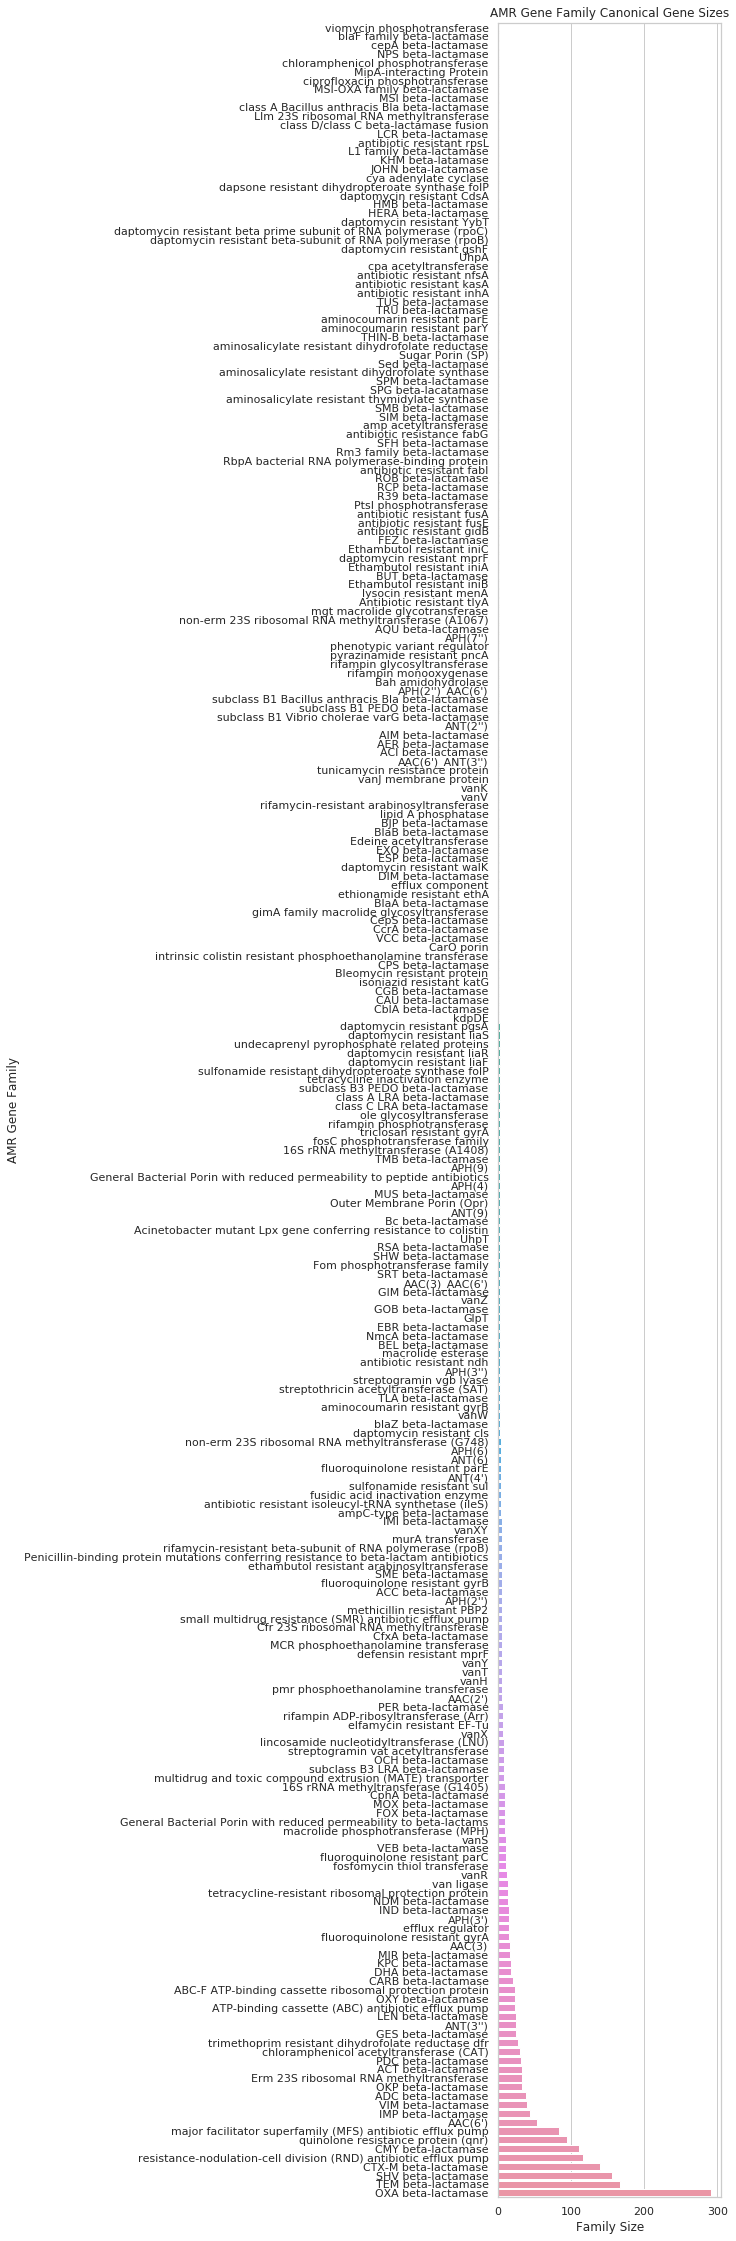

In [3]:
card = utils.CARD('../data/CARD_canonical/card.json')
df = pd.Series(card.family_sizes, name='Family Size').reset_index().rename(columns={'index': 'AMR Gene Family'})

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(4, 40)
sns.barplot(data = df.sort_values('Family Size'), x='Family Size', y='AMR Gene Family', ax=ax)
plt.title('AMR Gene Family Canonical Gene Sizes')
plt.savefig('figures/sup_family_sizes.svg')

In [4]:
df.to_csv('card_family_sizes')

,AMR Gene Family,Family Size
0,16S rRNA methyltransferase (A1408),2
1,16S rRNA methyltransferase (G1405),9
2,AAC(2'),6
3,AAC(3),16
4,AAC(3)_AAC(6'),2
5,AAC(6'),53
6,AAC(6')_ANT(3''),1
7,ABC-F ATP-binding cassette ribosomal protectio...,23
8,ACC beta-lactamase,5
9,ACI beta-lactamase,1


In [2]:
card = utils.CARD('../data/CARD_canonical/card.json')

nuc = pd.read_csv('family_sequence_diversity/card_nuc_vs_nuc.out6', sep='\t',
                  names='qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore'.split())

nuc['qseqid'] = nuc['qseqid'].str.split('|').str.get(4).str.replace('ARO:', '')
nuc['sseqid'] = nuc['sseqid'].str.split('|').str.get(4).str.replace('ARO:', '')

nuc = nuc[~nuc['qseqid'].isin(['3000489', '3000309', '3002818'])]
nuc = nuc[~nuc['sseqid'].isin(['3000489', '3000309', '3002818'])]

nuc['query_family'] = nuc['qseqid'].apply(lambda x: card.aro_to_gene_family[x])
nuc['subject_family'] = nuc['sseqid'].apply(lambda x: card.aro_to_gene_family[x])

# get top hit for each pair of query and subjects
top_hsp_per_hit = nuc.groupby(['qseqid', 'sseqid'])['bitscore'].nlargest(1).reset_index(level=0).reset_index(level=0).index
nuc = nuc.loc[top_hsp_per_hit]


# get self-hit bitscores
self_bitscore = nuc[nuc['qseqid'] == nuc['sseqid']]
self_bitscore = self_bitscore.drop_duplicates('qseqid').set_index('qseqid')['bitscore']

# reduce to only the subset we care about
nuc = nuc[['qseqid', 'sseqid', 'query_family', 'subject_family', 'bitscore']]

#filter nuc to samefamily only
within_family = nuc.query('query_family == subject_family')

# add all the missing hits in as 0s
for aro in tqdm(card.aro_to_gene_family.keys()):
    aro_hits = within_family[within_family['qseqid'] == aro]
    hit_aros = set(aro_hits['sseqid'].values)
    family = card.aro_to_gene_family[aro]
    family_aros = set(card.gene_family_to_aro[family])
    
    missing_family_hits = family_aros - hit_aros
    
    if len(hit_aros - family_aros) > 0:
        assert False
    
    missing_hits = {'qseqid': [], 'sseqid': [], 'query_family': [], 'subject_family': [], 'bitscore': []}
    for missed_aro in missing_family_hits:
        missing_hits['qseqid'].append(aro)
        missing_hits['sseqid'].append(missed_aro)
        missing_hits['query_family'].append(family)
        missing_hits['subject_family'].append(family)
        missing_hits['bitscore'].append(0)
    
    nuc = nuc.append(pd.DataFrame(missing_hits), ignore_index=True)
    

# drop self-hits
nuc = nuc.set_index('qseqid')
nuc['max_self_score'] = self_bitscore

nuc['bitscore_norm'] = nuc['bitscore'] / nuc['max_self_score']
nuc = nuc.reset_index()


nuc.to_csv('pairwise_nucleotide_blast_results.csv')

100%|██████████| 2409/2409 [01:47<00:00, 22.32it/s]


In [5]:
nuc = pd.read_csv('pairwise_nucleotide_blast_results.csv')

In [6]:
non_self = nuc.query('qseqid != sseqid')
#remove any with only 1 family member
singleton_families = [family for family in card.family_sizes if card.family_sizes[family] == 1]
non_self = non_self[~non_self['query_family'].isin(singleton_families)]


within_family = non_self.query('query_family == subject_family')
between_family = non_self.query('query_family != subject_family')

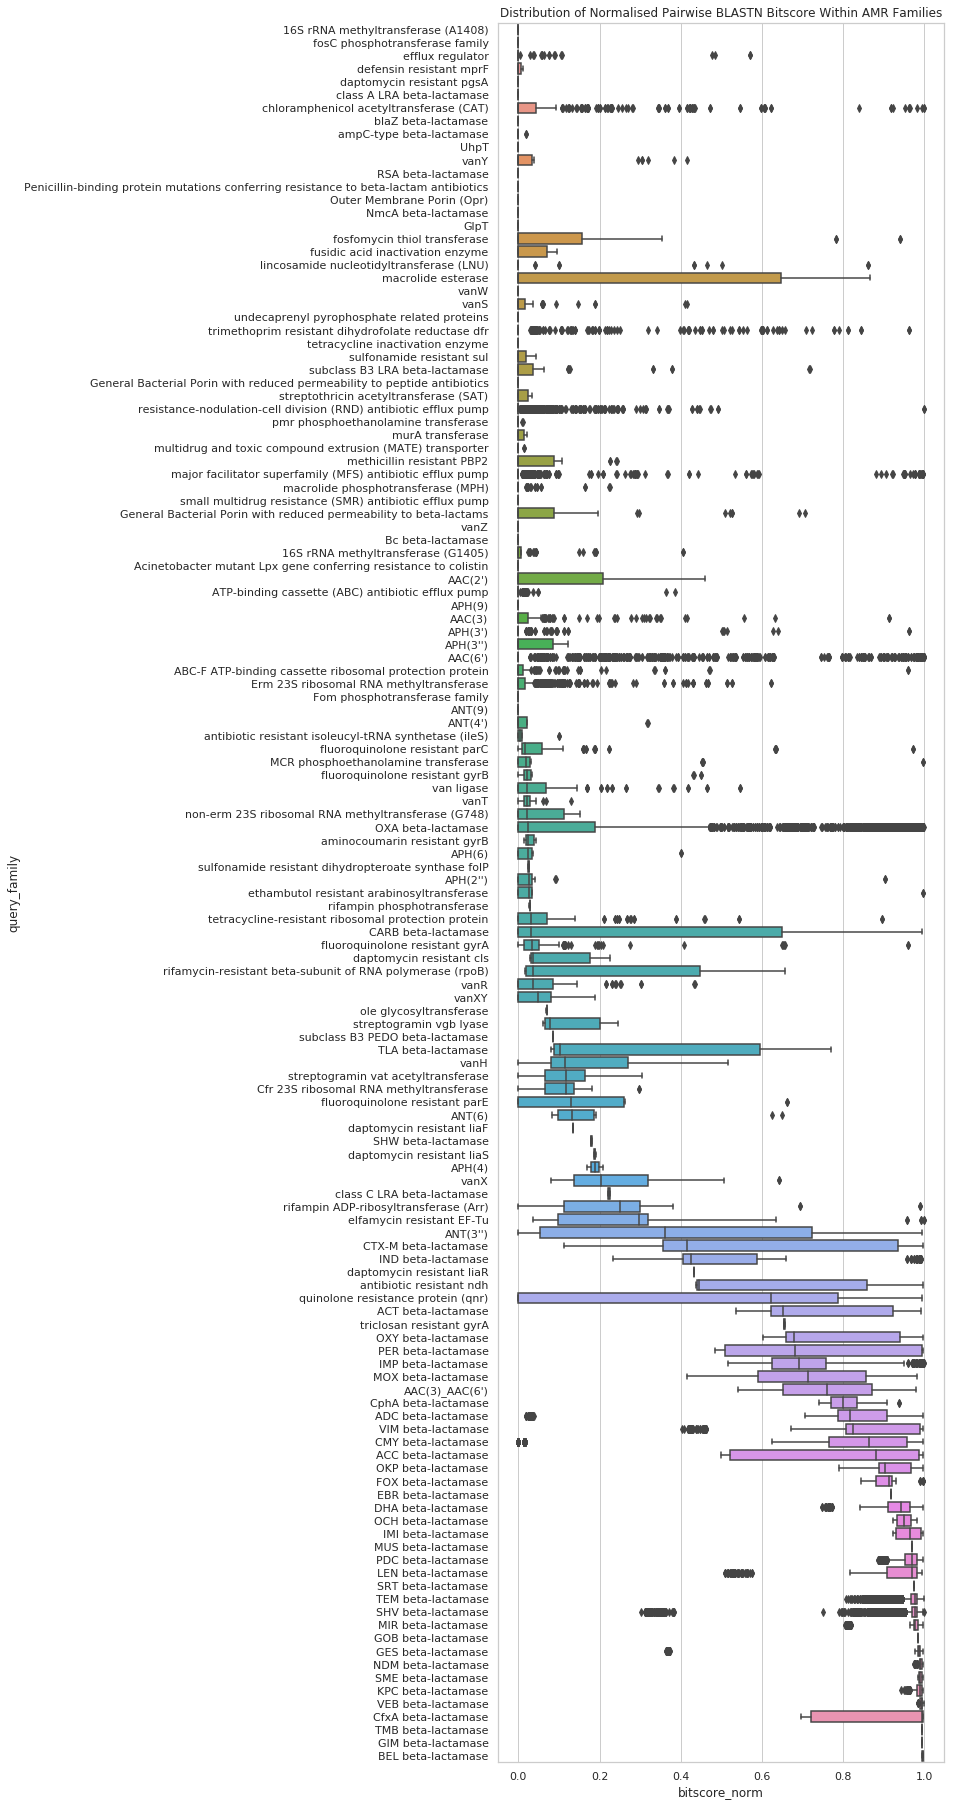

In [6]:
family_diversity_order = within_family.groupby('query_family')['bitscore_norm'].describe().sort_values('50%').index

plt.figure(figsize=(8, 32))
sns.boxplot(data = within_family, y='query_family', x='bitscore_norm', order = family_diversity_order)
plt.title("Distribution of Normalised Pairwise BLASTN Bitscore Within AMR Families")
plt.savefig('figures/sup_family_diversity.svg')

Text(0.5,1,'Distribution of Normalised Pairwise BLASTN Bitscore Within AMR Families')

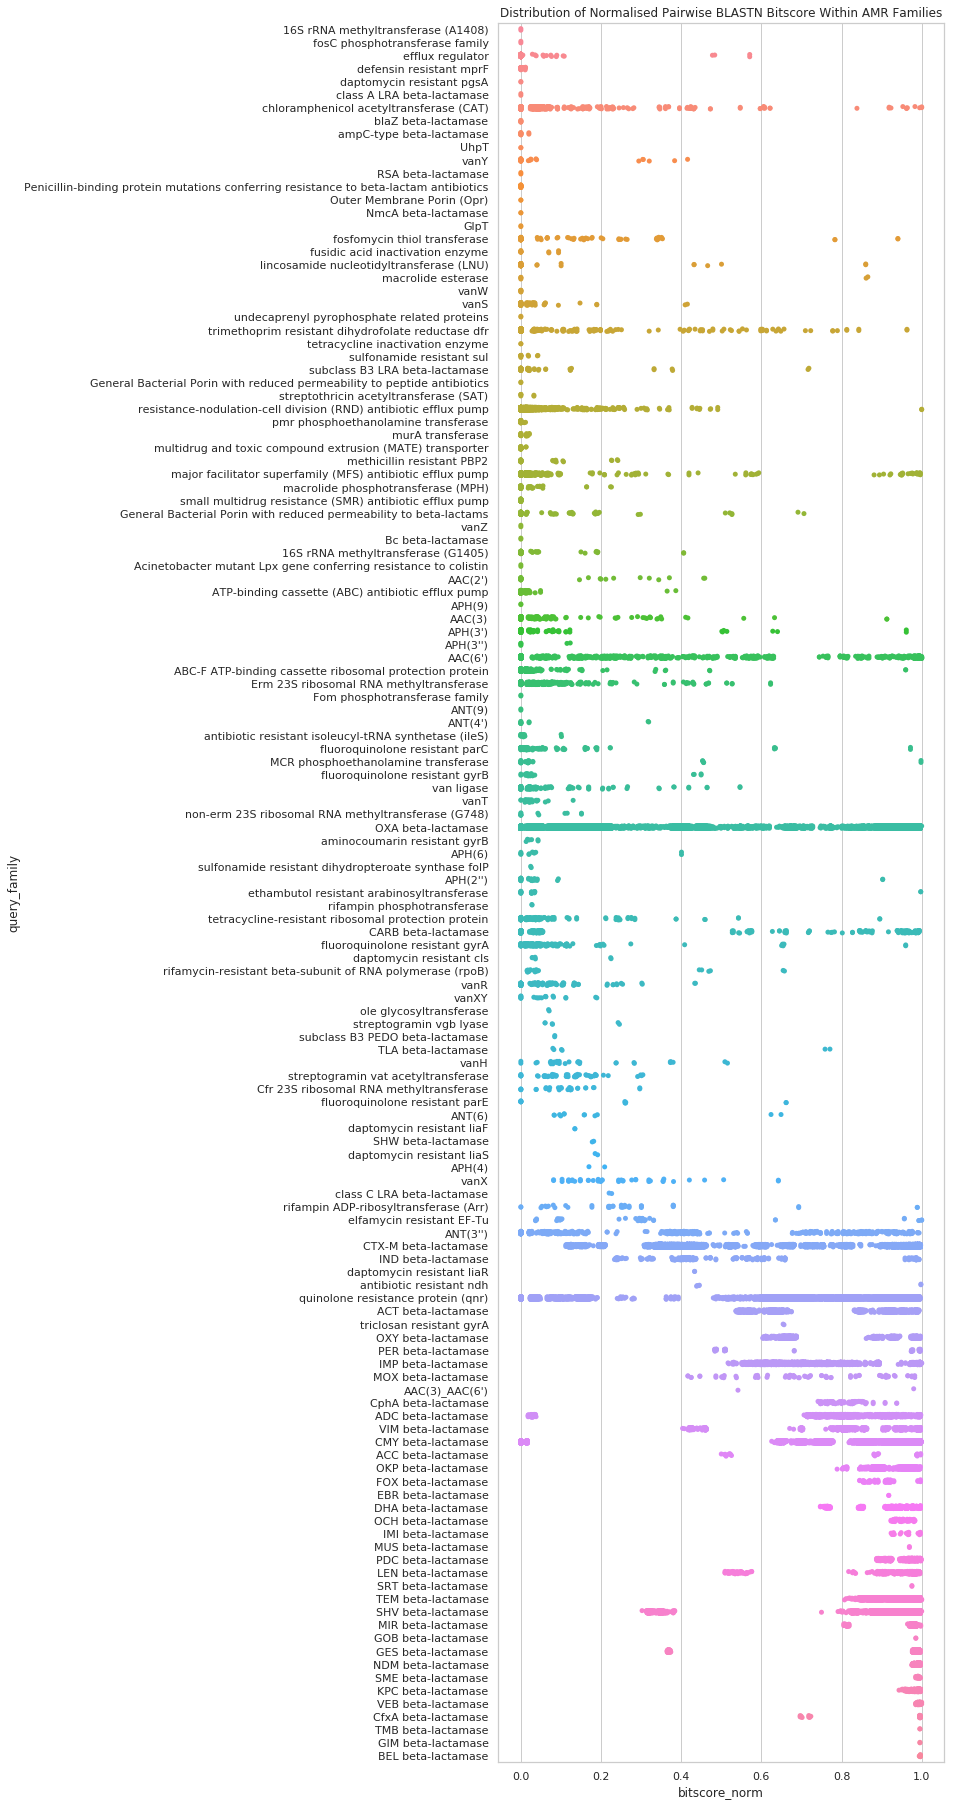

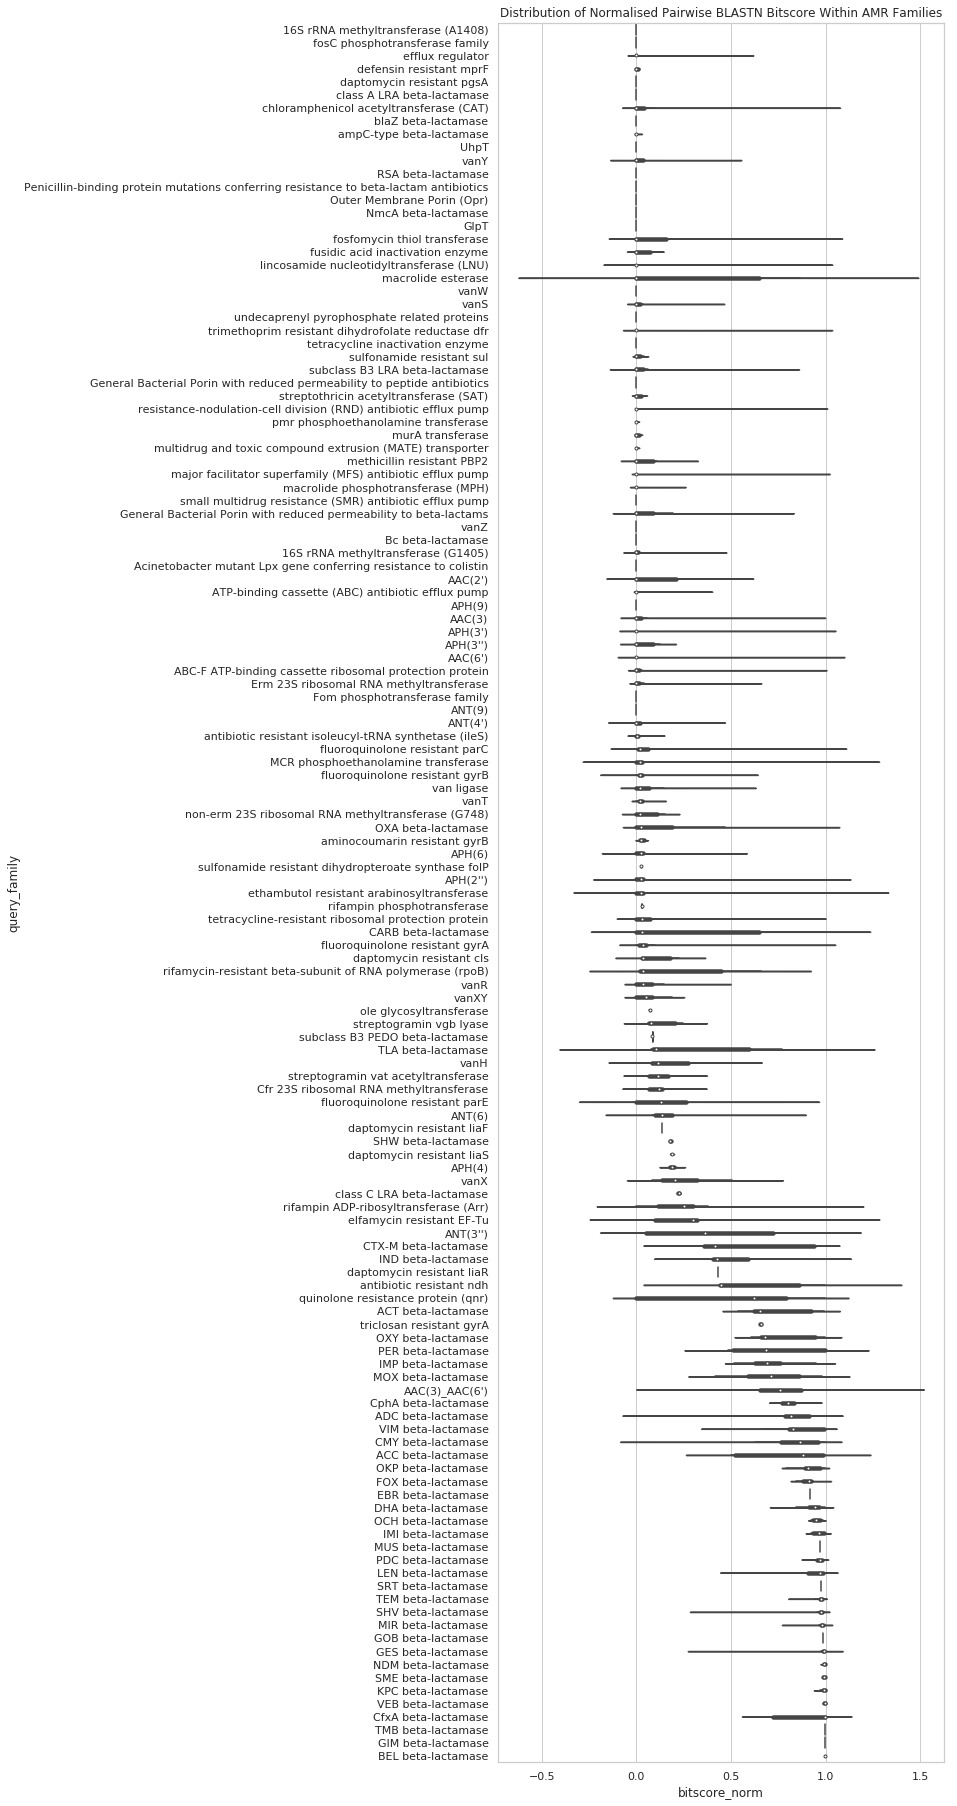

In [7]:

plt.figure(figsize=(8, 32))
sns.stripplot(data = within_family, y='query_family', x='bitscore_norm', order = family_diversity_order)
plt.title("Distribution of Normalised Pairwise BLASTN Bitscore Within AMR Families")


plt.figure(figsize=(8, 32))
sns.violinplot(data = within_family, y='query_family', x='bitscore_norm', order = family_diversity_order)
plt.title("Distribution of Normalised Pairwise BLASTN Bitscore Within AMR Families")

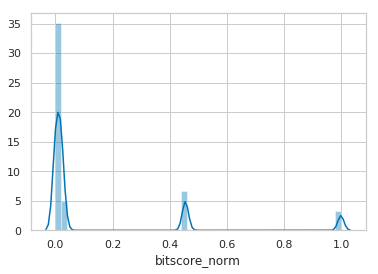

In [107]:
sns.distplot(within_family.query('query_family == "MCR phosphoethanolamine transferase"').sort_values('bitscore_norm')['bitscore_norm'])

In [109]:
# % of family that are > norm bitscore of first non_family_hit 

# normalised bitscore of the best hit to a sequence in another family
top_other_family_hit = between_family.groupby('query_family')['bitscore_norm'].nlargest(1).reset_index(level=1, drop=True)
# this is same length as number of families so should be fine
#assert len(top_other_family_hit) == len(card.family_sizes)

#non_self.sort_values(['query_family', 'bitscore_norm'], ascending=False).query('query_family != subject_family')

In [110]:
within_family = within_family.set_index('query_family')
within_family['other_family_top_hit'] = top_other_family_hit

Text(0.5,1,'Quantity of Family More Similar Than First Hit to Another Family')

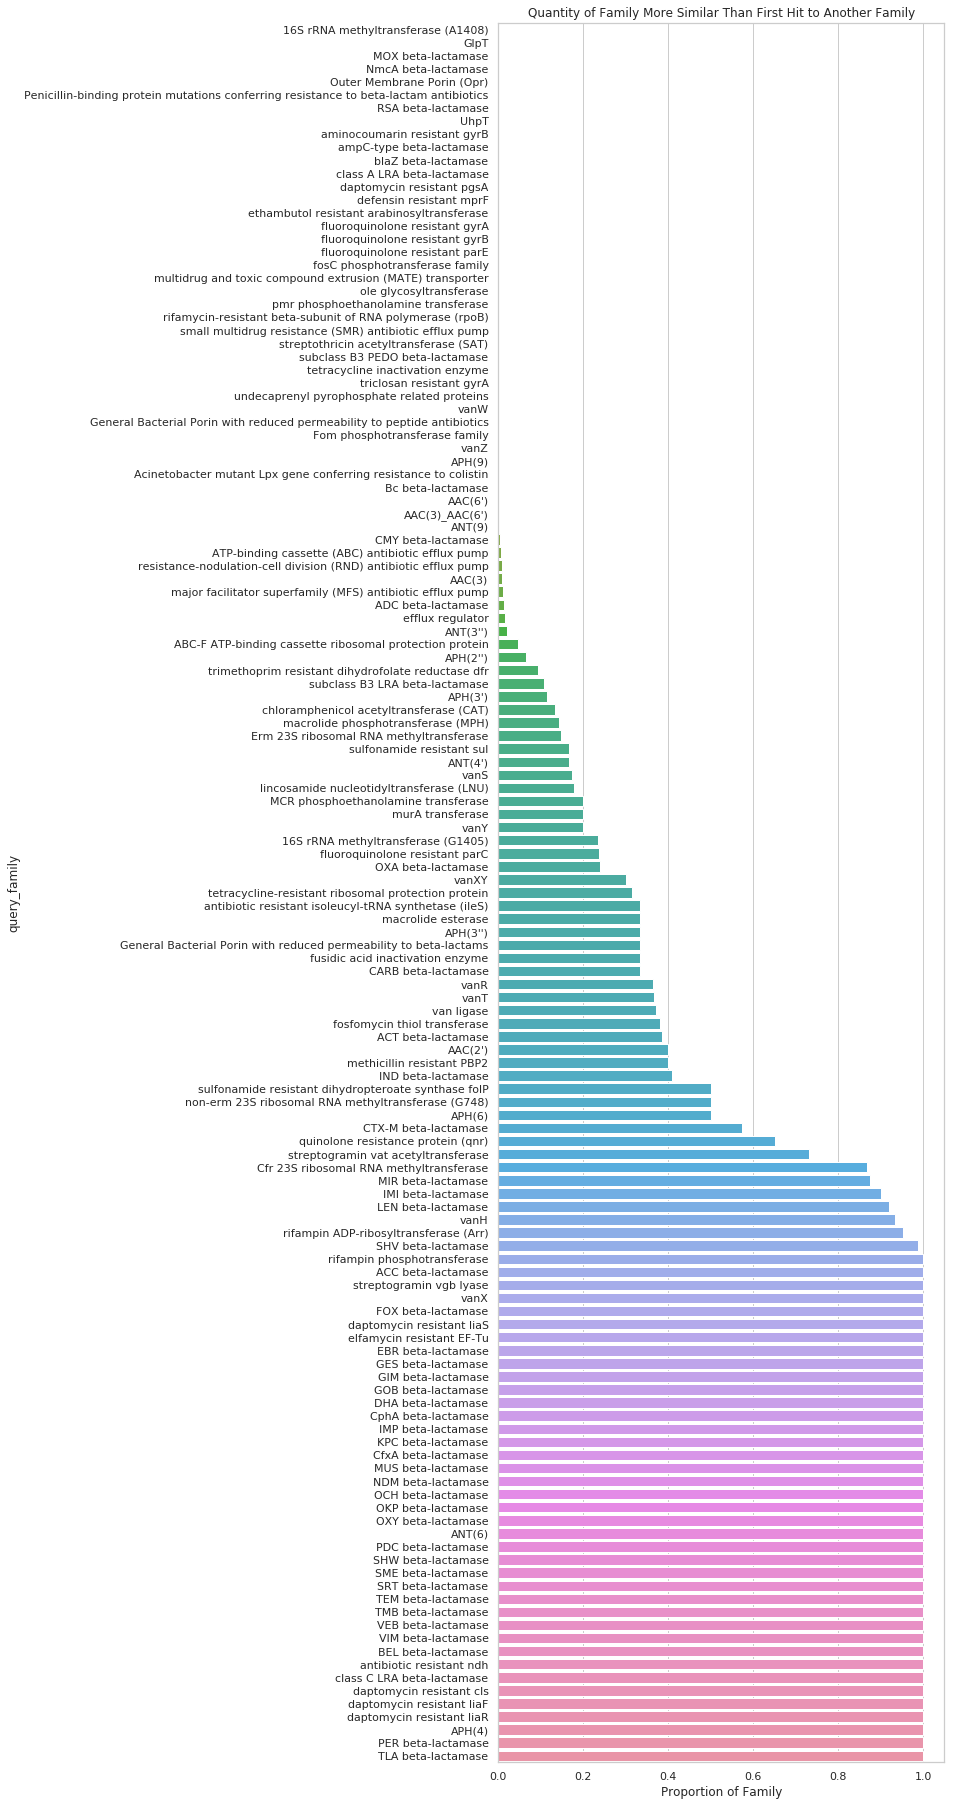

In [111]:
num_hits_within_family = within_family.query('bitscore_norm > other_family_top_hit').reset_index().groupby(['query_family']).size()

family_sizes = within_family.groupby('query_family').size()
purity = num_hits_within_family / family_sizes
purity = purity.fillna(0)


purity = purity.reset_index().sort_values(0).rename(columns={0: 'Proportion of Family'})
plt.figure(figsize=(8, 32))
sns.barplot(data = purity, y='query_family', x='Proportion of Family')
#sns.barplot(data = purity.sort_values()
plt.title('Quantity of Family More Similar Than First Hit to Another Family')

In [112]:
# total number of contaminants more similar than least similar family member

lowest_family_hit = within_family.groupby('query_family')['bitscore_norm'].nsmallest(1).reset_index(level=1, drop=True)

between_family = between_family.set_index('query_family')
between_family['min_family_hit'] = lowest_family_hit

num_contam_hits = between_family[between_family['bitscore_norm'] >= between_family['min_family_hit']].reset_index().groupby('query_family').size()

plt.figure(figsize=(8, 32))
sns.barplot(data = contams.sort_values('Number of Hits'), y='query_family', x='Number of Hits')
#sns.barplot(data = purity.sort_values()
plt.title('Quantity of Other Family Hits More Similar Than Most Divergent Family Member')

ValueError: No axis named Number of Hits for object type <class 'pandas.core.series.Series'>

<Figure size 576x2304 with 0 Axes>

In [138]:
num_contam_hits = between_family[between_family['bitscore_norm'] >= between_family['min_family_hit']].reset_index().groupby('query_family').size()
#num_contam_hits = 
prop_contam_within_most_divergent = num_contam_hits / non_self.groupby('query_family').size()
prop_contam_within_most_divergent =  prop_contam_within_most_divergent.fillna(0)
prop_contam_within_most_divergent = prop_contam_within_most_divergent.reset_index().rename(columns={0: 'Normalised Bitscore Impurity'})


single_fams = []
for family in singleton_families:
    single_fams.append([family, 0])
    
prop_contam_within_most_divergent = prop_contam_within_most_divergent.append(pd.DataFrame(single_fams, 
                                                                             columns=['query_family', 'Normalised Bitscore Impurity']),
                                                                            ignore_index=True)


prop_contam_within_most_divergent.to_pickle('contamination_per_family.pkl')

In [ ]:
ACC beta-lactamase

In [115]:
card.family_sizes['ACC beta-lactamase']

5

In [118]:
any(between_family.loc['ACC beta-lactamase'].sort_values('subject_family')['bitscore_norm'] > 0.5)

False

In [90]:
card.family_sizes

Counter({'16S rRNA methyltransferase (A1408)': 2,
         '16S rRNA methyltransferase (G1405)': 9,
         "AAC(2')": 6,
         'AAC(3)': 16,
         "AAC(3)_AAC(6')": 2,
         "AAC(6')": 53,
         "AAC(6')_ANT(3'')": 1,
         'ABC-F ATP-binding cassette ribosomal protection protein': 23,
         'ACC beta-lactamase': 5,
         'ACI beta-lactamase': 1,
         'ACT beta-lactamase': 33,
         'ADC beta-lactamase': 38,
         'AER beta-lactamase': 1,
         'AIM beta-lactamase': 1,
         "ANT(2'')": 1,
         "ANT(3'')": 25,
         "ANT(4')": 4,
         'ANT(6)': 4,
         'ANT(9)': 2,
         "APH(2'')": 6,
         "APH(2'')_AAC(6')": 1,
         "APH(3'')": 3,
         "APH(3')": 15,
         'APH(4)': 2,
         'APH(6)': 4,
         "APH(7'')": 1,
         'APH(9)': 2,
         'AQU beta-lactamase': 1,
         'ATP-binding cassette (ABC) antibiotic efflux pump': 23,
         'Acinetobacter mutant Lpx gene conferring resistance to colistin': 2,
 

In [78]:
lowest_family_hit

query_family
16S rRNA methyltransferase (A1408)                                  0.000000
16S rRNA methyltransferase (G1405)                                  0.000000
AAC(2')                                                             0.000000
AAC(3)                                                              0.000000
AAC(3)_AAC(6')                                                      0.541644
AAC(6')                                                             0.000000
ABC-F ATP-binding cassette ribosomal protection protein             0.000000
ACC beta-lactamase                                                  0.500000
ACT beta-lactamase                                                  0.536043
ADC beta-lactamase                                                  0.018199
ANT(3'')                                                            0.000000
ANT(4')                                                             0.000000
ANT(6)                                                         

In [73]:
contams

16S rRNA methyltransferase (A1408)                                  2
16S rRNA methyltransferase (G1405)                                  9
AAC(2')                                                             6
AAC(3)                                                             16
AAC(3)_AAC(6')                                                      2
AAC(6')                                                            53
AAC(6')_ANT(3'')                                                    1
ABC-F ATP-binding cassette ribosomal protection protein            23
ACC beta-lactamase                                                  5
ACI beta-lactamase                                                  1
ACT beta-lactamase                                                 33
ADC beta-lactamase                                                 38
AER beta-lactamase                                                  1
AIM beta-lactamase                                                  1
ANT(2'')            

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


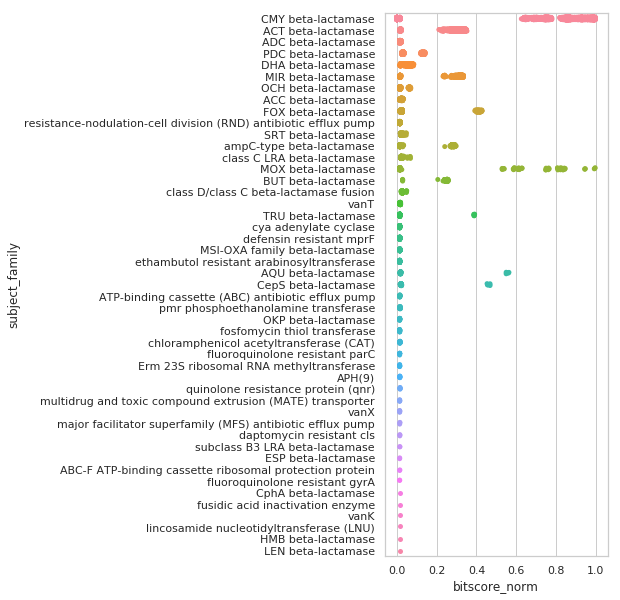

In [39]:
cmy = non_self.query('query_family == "CMY beta-lactamase"')
cmy.loc[cmy.query('query_family==subject_family').index,'type'] = "Within Family"
cmy.loc[cmy.query('query_family!=subject_family').index,'type'] = "Other Family"
order = cmy['subject_family'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(4,10))
sns.stripplot(data = cmy, x='bitscore_norm', y='subject_family', order=order)

In [44]:
non_self.loc[non_self.query('query_family==subject_family').index,'type'] = "Within Family"
non_self.loc[non_self.query('query_family!=subject_family').index,'type'] = "Other Family"

#plt.figure(figsize=(8, 50))
#sns.stripplot(data = non_self, y='query_family', x='bitscore_norm', hue='type')

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [45]:
bl = non_self[non_self['query_family'].str.endswith('lactamase')]

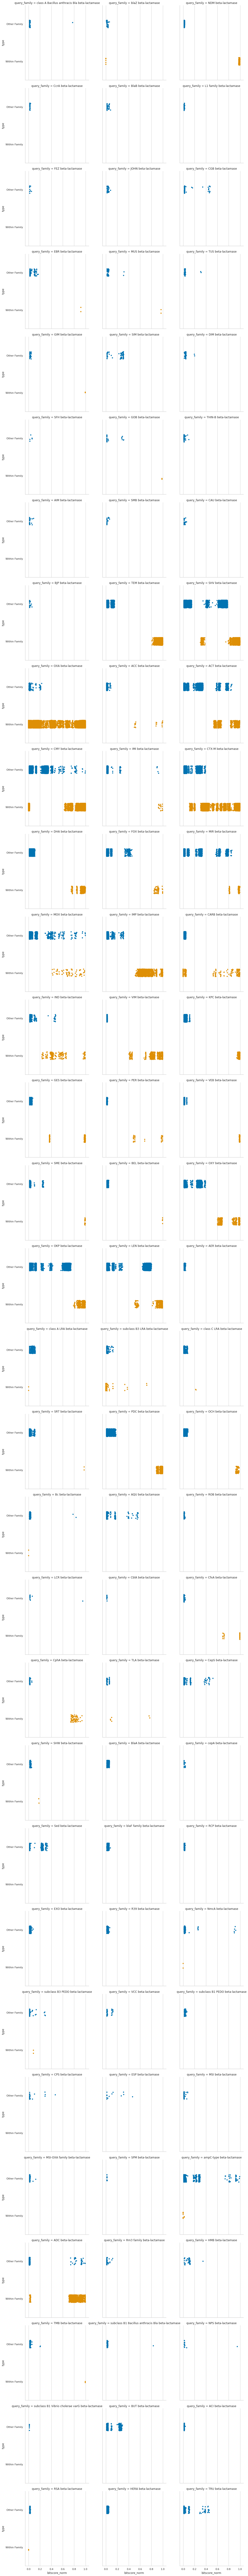

In [46]:
sns.catplot(kind='strip', data = bl, col='query_family', col_wrap=3, y='type', x='bitscore_norm')